# Software Requirements Classification
## Best model selection

### Data Preprocessing

In [372]:
import pandas as pd

df = pd.read_csv('software_requirements_extended.csv') # Load the dataset
df['Type'] = df['Type'].apply(lambda x: 1 if x == 'FR' or x == 'F' else 0)
df.head() # Display the first 5 rows to check the data

,Type,Requirement
0,0,The system shall refresh the display every 60 ...
1,0,The application shall match the color of the s...
2,0,If projected the data must be readable. On ...
3,0,The product shall be available during normal ...
4,0,If projected the data must be understandable...


In [373]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import *
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/nickbres/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/nickbres/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

Create function to clean the text. With stemming or lemmatization

In [374]:
# Pre-load stopwords to improve efficiency
STOPWORDS = set(stopwords.words("english"))

# Expanded pattern to potentially keep useful punctuation or additional cleaning
pattern_without_numbers = re.compile(r"[^a-zA-Z]")
pattern_with_numbers = re.compile(r"[^\w\d]")

def req_to_words(req, delete_stopwords, with_numbers, normalize_numbers,lemmatize = False,stemming = False,):
    """Convert requirement text into a sequence of 'clean' words"""
    # Convert to lower case
    text = req.lower()

    if with_numbers:
        pattern = pattern_with_numbers
    else:
        pattern = pattern_without_numbers

    if with_numbers and normalize_numbers:
        text = re.sub(r'\b\d+\b', 'num', text)

    # Remove unwanted characters
    text = re.sub(pattern, " ", text)

    # Tokenize
    words = text.split()

    # Remove stopwords
    if delete_stopwords:
        words = [w for w in words if w not in STOPWORDS]

    # Apply lemmatization or stemming
    if lemmatize:
        words = [ WordNetLemmatizer().lemmatize(w) for w in words]
    elif stemming: # Stemming
        words = [PorterStemmer().stem(w) for w in words]

    # join the words back into one string
    clean_req = " ".join(words)

    return clean_req

### Models
Now we will create different models with best hyperparameters and cleaning methods (got earlier) and compare them.

#### Logistic Regression

In [375]:
from sklearn.linear_model import LogisticRegression

preprocessing_params_logR = {
    'lemmatize': True, # use lemmatization false by default
    'stemming': False, # use stemming false by default
    'delete_stopwords': True, # delete stopwords like 'the', 'and', etc.
    'with_numbers': True, # keep numbers or not
    'normalize_numbers': True # normalize numbers to a single token (will only work if with_numbers is True)
}

logR = LogisticRegression(
    C=1,  
    penalty='none', 
    solver='saga',  
    max_iter=300 
)

#### KNN

In [376]:
from sklearn.neighbors import KNeighborsClassifier

preprocessing_params_knn = {
    'lemmatize': True, # use lemmatization false by default
    'stemming': False, # use stemming false by default
    'delete_stopwords': False, # delete stopwords like 'the', 'and', etc.
    'with_numbers': True, # keep numbers or not
    'normalize_numbers': True # normalize numbers to a single token (will only work if with_numbers is True)
}

knn = KNeighborsClassifier(
    metric='euclidean',
    n_neighbors=1,
    weights='uniform'
)

#### Naive Bayes

In [377]:
from sklearn.naive_bayes import MultinomialNB

preprocessing_params_nb = {
    'lemmatize': False, # use lemmatization false by default
    'stemming': False, # use stemming false by default
    'delete_stopwords': False, # delete stopwords like 'the', 'and', etc.
    'with_numbers': True, # keep numbers or not
    'normalize_numbers': False # normalize numbers to a single token (will only work if with_numbers is True)
}

nb = MultinomialNB(
    alpha=0.1
)

#### SVC

In [378]:
from sklearn.svm import SVC

preprocessing_params_svc = {
    'lemmatize': True, # use lemmatization false by default
    'stemming': False, # use stemming false by default
    'delete_stopwords': True, # delete stopwords like 'the', 'and', etc.
    'with_numbers': True, # keep numbers or not
    'normalize_numbers': False # normalize numbers to a single token (will only work if with_numbers is True)
}

svc = SVC(
    C=10, 
    gamma=1, 
    kernel='rbf',
    probability=True
)

#### Decision Tree

In [379]:
from sklearn.tree import DecisionTreeClassifier

preprocessing_params_dtc = {
    'lemmatize': False, # use lemmatization false by default
    'stemming': False, # use stemming false by default
    'delete_stopwords': True, # delete stopwords like 'the', 'and', etc.
    'with_numbers': True, # keep numbers or not
    'normalize_numbers': False # normalize numbers to a single token (will only work if with_numbers is True)
}

dtc = DecisionTreeClassifier(
    criterion='entropy',
    max_depth=50,
    min_samples_leaf=1,
    min_samples_split=10
)

#### Decision Tree with AdaBoost

In [380]:
from sklearn.ensemble import AdaBoostClassifier

ada_dtc = AdaBoostClassifier(
    estimator=DecisionTreeClassifier(
        criterion='entropy',
        max_depth=50,
        min_samples_leaf=1,
        min_samples_split=10
    ),
    n_estimators=100,
    learning_rate=0.1
)

#### Hard Voting

In [381]:
from sklearn.ensemble import VotingClassifier

preprocessing_params_voting = {
    'lemmatize': True, # use lemmatization false by default
    'stemming': False, # use stemming false by default
    'delete_stopwords': True, # delete stopwords like 'the', 'and', etc.
    'with_numbers': True, # keep numbers or not
    'normalize_numbers': False # normalize numbers to a single token (will only work if with_numbers is True)
}

voting_clf_hard = VotingClassifier(
    estimators=[('lr', logR), ('svc', svc), ('dt', dtc), ('nb', nb), ('knn', knn), ('ada', ada_dtc)],
    voting='hard'
)

#### Soft Voting

In [382]:
voting_clf_soft = VotingClassifier(
    estimators=[('lr', logR), ('svc', svc), ('dt', dtc), ('nb', nb), ('knn', knn), ('ada', ada_dtc)],
    voting='soft'
)

### Testing

In [383]:
import time
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np

def run_model_evaluation(df,model, n, preprocessing_params):
    """
    Evaluate a model by splitting the data n times into training and testing sets,
    fitting the model, and calculating the accuracy in percent.
    
    Parameters:
    - df: The dataset to be used.
    - model: The machine learning model to be evaluated.
    - n: The number of times to repeat the process.
    - preprocessing_params: A dictionary of preprocessing parameters.
    
    Returns:
    - accuracies: An array of accuracy scores (in percent) from each iteration.
    """
    accuracies = []
    
    # measure time of execution
    start = time.time()

    # Extract preprocessing parameters
    lemmatize = preprocessing_params.get('lemmatize', False)
    stemming = preprocessing_params.get('stemming', False)
    delete_stopwords = preprocessing_params.get('delete_stopwords', True)
    with_numbers = preprocessing_params.get('with_numbers', True)
    normalize_numbers = preprocessing_params.get('normalize_numbers', True)

    # Prepare the data
    y = df['Type']
    # Preprocess the requirements to convert them into 'clean' words
    X = [req_to_words(req, lemmatize=lemmatize,stemming= stemming, delete_stopwords=delete_stopwords, with_numbers=with_numbers, normalize_numbers=normalize_numbers) for req in df['Requirement']]

    for _ in range(n):
        # Split the data
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
    
        # Vectorize the text
        vectorizer = TfidfVectorizer()
        X_train = vectorizer.fit_transform(X_train)
        X_test = vectorizer.transform(X_test)

        # Fit the model
        model.fit(X_train, y_train)

        # Predict and evaluate
        y_pred = model.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred) * 100  # Convert accuracy to percent
        accuracies.append(accuracy)

    # measure time of execution
    total_time = time.time() - start
    
    return accuracies, total_time

In [384]:
n = 10  # Number of iterations

In [385]:
# Logistic Regression
logR_accuracies, logR_time= run_model_evaluation(df,logR, n, preprocessing_params_logR)
print("Logistic Regression:", np.mean(logR_accuracies), "%")
print(f"Time: {logR_time:.2f} s")

/Users/nickbres/anaconda3/envs/SoftwareRequirements/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1182: FutureWarning:

`penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.

/Users/nickbres/anaconda3/envs/SoftwareRequirements/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

/Users/nickbres/anaconda3/envs/SoftwareRequirements/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1182: FutureWarning:

`penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.

/Users/nickbres/anaconda3/envs/SoftwareRequirements/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

/Users/nickbres/anaconda3/envs/SoftwareRequirements/lib/python3.8/site-packages/sklearn/

Logistic Regression: 87.14285714285714 %
Time: 0.34 s


/Users/nickbres/anaconda3/envs/SoftwareRequirements/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1182: FutureWarning:

`penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.

/Users/nickbres/anaconda3/envs/SoftwareRequirements/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

/Users/nickbres/anaconda3/envs/SoftwareRequirements/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1182: FutureWarning:

`penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.

/Users/nickbres/anaconda3/envs/SoftwareRequirements/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

/Users/nickbres/anaconda3/envs/SoftwareRequirements/lib/python3.8/site-packages/sklearn/

In [386]:
# KNN
knn_accuracies, knn_time = run_model_evaluation(df,knn, n, preprocessing_params_knn) 
print("KNN :", np.mean(knn_accuracies), "%")
print(f"Time: {knn_time:.2f} s")

KNN : 87.65306122448979 %
Time: 0.34 s


In [387]:
# Naive Bayes
nb_accuracies, nb_time = run_model_evaluation(df,nb, n, preprocessing_params_nb)
print("Naive Bayes :", np.mean(nb_accuracies), "%")
print(f"Time: {nb_time:.2f} s")

Naive Bayes : 88.29931972789117 %
Time: 0.14 s


In [388]:
# SVC
svc_accuracies, svc_time = run_model_evaluation(df,svc, n, preprocessing_params_svc)
print("SVC :", np.mean(svc_accuracies), "%")
print(f"Time: {svc_time:.2f} s")

SVC : 89.14965986394557 %
Time: 2.10 s


In [389]:
# Decision Tree
dtc_accuracies, dtc_time = run_model_evaluation(df,dtc, n, preprocessing_params_dtc) 
print("Decision Tree :", np.mean(dtc_accuracies), "%")
print(f"Time: {dtc_time:.2f} s")

Decision Tree : 77.68707482993197 %
Time: 0.23 s


In [390]:
# Decision Tree with AdaBoost
ada_dtc_accuracies, ada_dtc_time = run_model_evaluation(df,ada_dtc, n, preprocessing_params_dtc) 
print("Decision Tree with AdaBoost :", np.mean(ada_dtc_accuracies), "%")
print(f"Time: {ada_dtc_time:.2f} s")

Decision Tree with AdaBoost : 79.38775510204081 %
Time: 23.13 s


In [391]:
# Hard Voting
voting_clf_hard_accuracies, voting_clf_hard_time = run_model_evaluation(df,voting_clf_hard, n, preprocessing_params_voting)
print("Hard Voting :", np.mean(voting_clf_hard_accuracies), "%")
print(f"Time: {voting_clf_hard_time:.2f} s")

/Users/nickbres/anaconda3/envs/SoftwareRequirements/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1182: FutureWarning:

`penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.

/Users/nickbres/anaconda3/envs/SoftwareRequirements/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

/Users/nickbres/anaconda3/envs/SoftwareRequirements/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1182: FutureWarning:

`penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.

/Users/nickbres/anaconda3/envs/SoftwareRequirements/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

/Users/nickbres/anaconda3/envs/SoftwareRequirements/lib/python3.8/site-packages/sklearn/

Hard Voting : 89.31972789115646 %
Time: 22.49 s


In [392]:
# Soft Voting
voting_clf_soft_accuracies, voting_clf_soft_time = run_model_evaluation(df,voting_clf_soft, n, preprocessing_params_voting) 
print("Soft Voting :", np.mean(voting_clf_soft_accuracies), "%")
print(f"Time: {voting_clf_soft_time:.2f} s")

/Users/nickbres/anaconda3/envs/SoftwareRequirements/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1182: FutureWarning:

`penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.

/Users/nickbres/anaconda3/envs/SoftwareRequirements/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

/Users/nickbres/anaconda3/envs/SoftwareRequirements/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1182: FutureWarning:

`penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.

/Users/nickbres/anaconda3/envs/SoftwareRequirements/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

/Users/nickbres/anaconda3/envs/SoftwareRequirements/lib/python3.8/site-packages/sklearn/

Soft Voting : 88.843537414966 %
Time: 23.61 s


In [393]:
def plot_accuracy_over_runs(n_runs, accuracies, models):
    """
    Plot a graph showing the accuracy of each model over n runs.
    
    Parameters:
    - n_runs: List or array of run numbers (e.g., [1, 2, ..., n]).
    - accuracies: Dictionary with model names as keys and lists of accuracies as values.
    - models: List of model names.
    """
    plt.figure(figsize=(10, 6))  # Create a single figure

    # Plot accuracies 
    for model in models:
        plt.plot(n_runs, accuracies[model], '-o', label=model)
    plt.title('Model Accuracies Over Runs')
    plt.xlabel('Run Number')  # Adding X label since 'sharex' is no longer applicable
    plt.ylabel('Accuracy (%)')
    plt.legend()

    plt.tight_layout()
    plt.show()


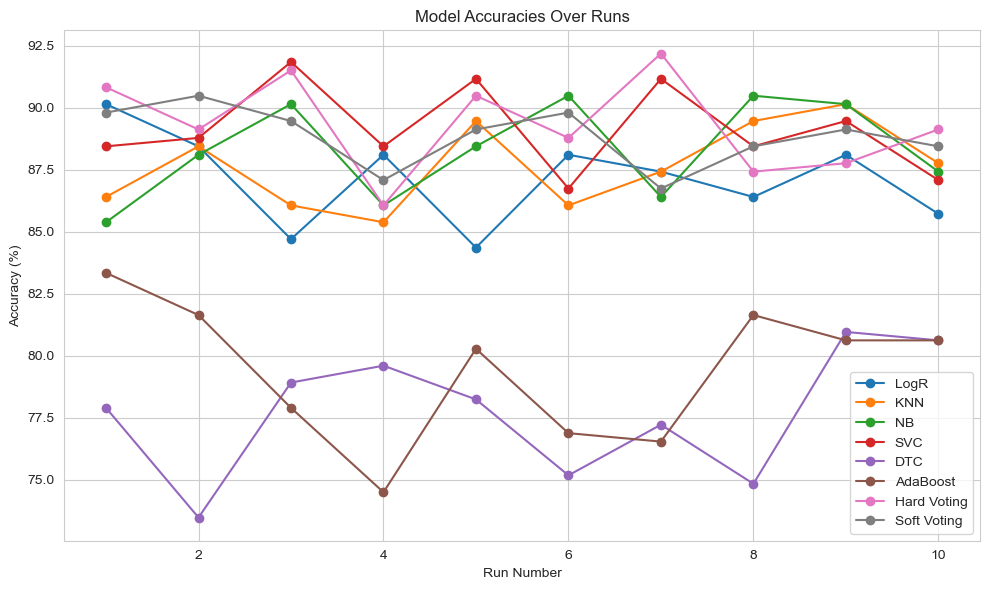

In [394]:
# Prepare the data for plotting
n_runs = list(range(1, n + 1))  # Create a list of runs for the x-axis
models = ['LogR', 'KNN', 'NB', 'SVC', 'DTC', 'AdaBoost', 'Hard Voting', 'Soft Voting']  # List your models


accuracies = {
    'LogR': logR_accuracies,
    'KNN': knn_accuracies,
    'NB': nb_accuracies,
    'SVC': svc_accuracies,
    'DTC': dtc_accuracies,
    'AdaBoost': ada_dtc_accuracies,
    'Hard Voting': voting_clf_hard_accuracies,
    'Soft Voting': voting_clf_soft_accuracies
}
plot_accuracy_over_runs(n_runs, accuracies, models)

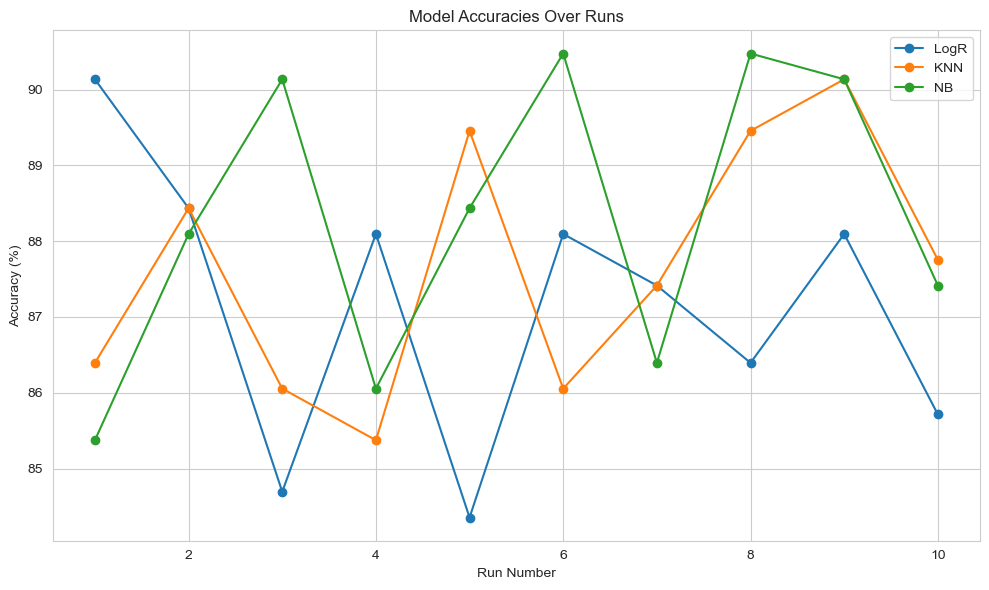

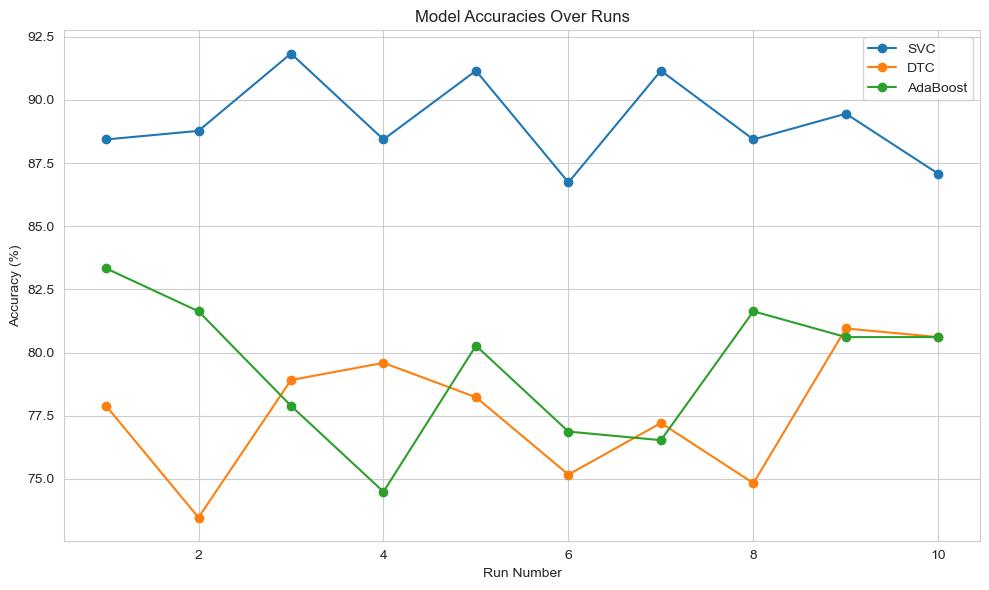

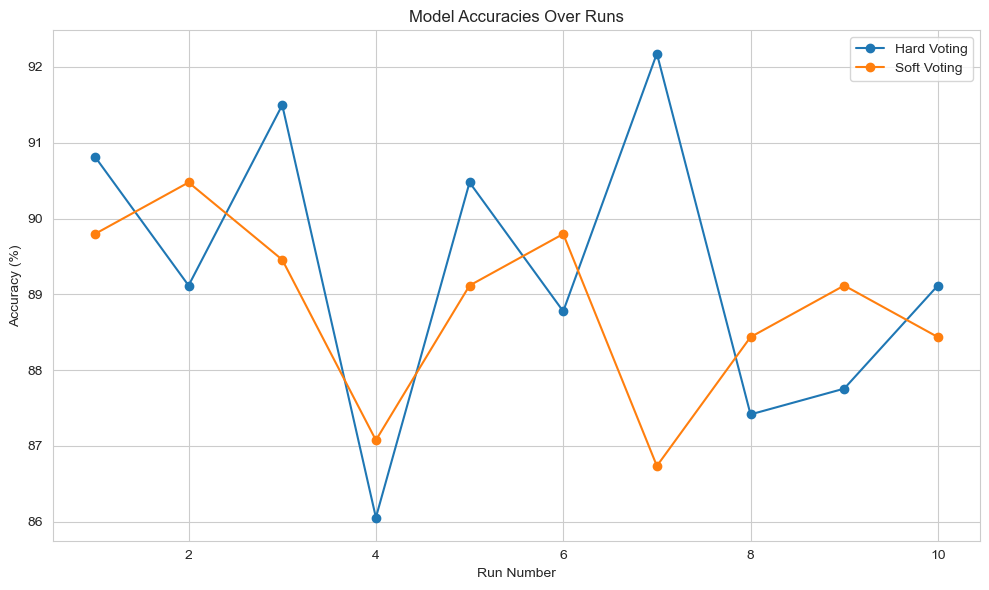

In [395]:
# Splitting models into groups
group1_models = ['LogR', 'KNN', 'NB']
group2_models = ['SVC', 'DTC', 'AdaBoost']
group3_models = ['Hard Voting', 'Soft Voting']

# Group 1 accuracies
group1_accuracies = {model: accuracies[model] for model in group1_models}
# Group 2 accuracies
group2_accuracies = {model: accuracies[model] for model in group2_models}
# Group 3 accuracies
group3_accuracies = {model: accuracies[model] for model in group3_models}

# Plotting each group
plot_accuracy_over_runs(n_runs, group1_accuracies, group1_models)
plot_accuracy_over_runs(n_runs, group2_accuracies, group2_models)
plot_accuracy_over_runs(n_runs, group3_accuracies, group3_models)


In [396]:
import numpy as np

def plot_mean_accuracies_and_annotate_best_model(accuracies, models):
    """
    Plot a graph of the mean accuracies for all models and annotate the best model.
    
    Parameters:
    - accuracies: Dictionary with model names as keys and accuracies as values.
    - models: List of model names.
    
    Returns:
    - best_model: The name of the best model.
    """
    # Calculate mean accuracies
    means = {model: np.mean(acc) for model, acc in accuracies.items()}

    # Determine the best model
    best_model, best_score = max(means.items(), key=lambda x: x[1])

    # Plot the mean accuracies
    fig, ax = plt.subplots(figsize=(10, 6))
    x = np.arange(len(models))  # the label locations
    width = 0.35  # the width of the bars

    rects = ax.bar(x, means.values(), width, label='Accuracy')

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('Mean Accuracy (%)')
    ax.set_title('Mean Accuracy by Model')
    ax.set_xticks(x)
    ax.set_xticklabels(models)
    ax.legend(loc='lower center')

    # Annotate
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}%',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

    # Highlight the best model
    best_rect = rects[x[models.index(best_model)]]
    best_rect.set_color('green')
    ax.annotate('Best Model',
                xy=(best_rect.get_x() + best_rect.get_width() / 2, best_rect.get_height()),
                xytext=(0, 3),  # 3 points vertical offset
                textcoords="offset points",
                ha='center', va='bottom',
                fontsize=10,
                fontweight='bold',
                color='white')

    plt.tight_layout()
    plt.show()

    return best_model, means[best_model]

In [397]:
# Plot total times for each model
def plot_model_times(model_times):
    models = list(model_times.keys())
    times = list(model_times.values())

    fig, ax = plt.subplots(figsize=(10, 6))
    ax.bar(models, times, color='skyblue')

    ax.set_ylabel('Total Time (seconds)')
    ax.set_title('Total Time Taken for Each Model Over N Iterations')
    ax.set_xticklabels(models, rotation=45)

    for i, time in enumerate(times):
        ax.text(i, time + 0.05, f'{time:.2f}', ha='center')

    plt.tight_layout()
    plt.show()

/var/folders/71/vnznjlz52qj_1p44k0hb7sw00000gn/T/ipykernel_77612/849270222.py:11: UserWarning:

FixedFormatter should only be used together with FixedLocator



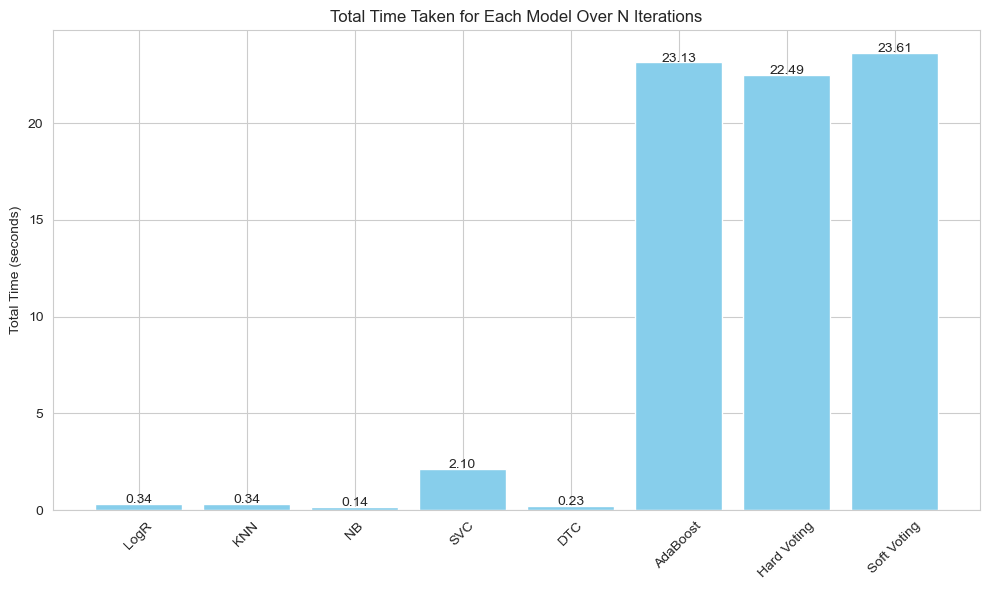

In [398]:
model_times = {
    'LogR': logR_time,
    'KNN': knn_time,
    'NB': nb_time,
    'SVC': svc_time,
    'DTC': dtc_time,
    'AdaBoost': ada_dtc_time,
    'Hard Voting': voting_clf_hard_time,
    'Soft Voting': voting_clf_soft_time
}
plot_model_times(model_times)

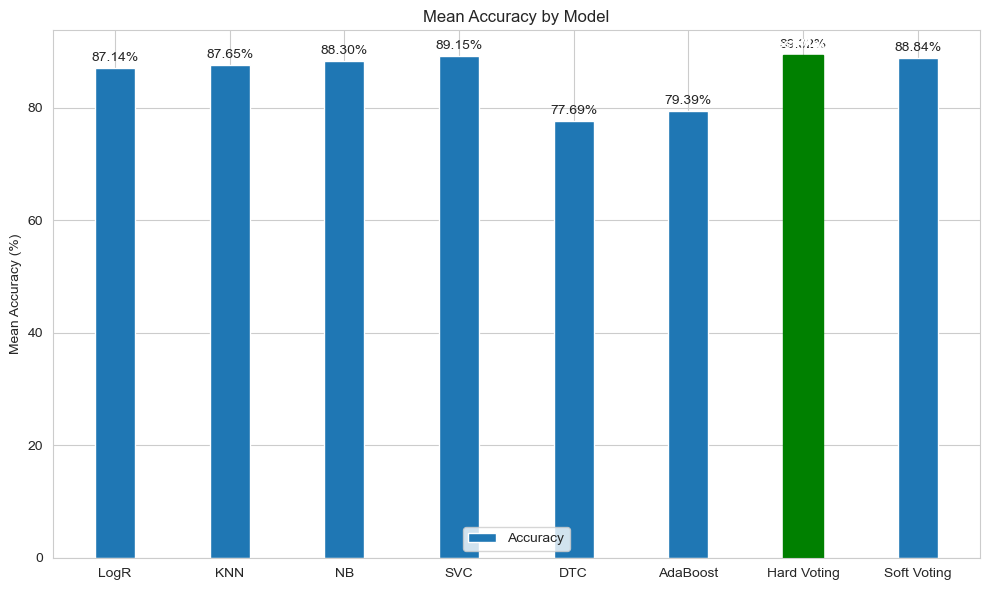

The best model is Hard Voting with an accuracy of 89.32%.


In [399]:
best_model_name, best_accuracy = plot_mean_accuracies_and_annotate_best_model(accuracies, models)
print(f"The best model is {best_model_name} with an accuracy of {best_accuracy:.2f}%.")

### Best Model Tests
Based on the previous results, we will use the best model to test it on some examples not from dataset.

In [400]:
best_model = None
best_model_preprocess = None
if best_model_name == 'LogR':
    best_model = logR
    best_model_preprocess = preprocessing_params_logR
elif best_model_name == 'KNN':
    best_model = knn
    best_model_preprocess = preprocessing_params_knn
elif best_model_name == 'NB':
    best_model = nb
    best_model_preprocess = preprocessing_params_nb
elif best_model_name == 'SVC':
    best_model = svc
    best_model_preprocess = preprocessing_params_svc
elif best_model_name == 'DTC':
    best_model = dtc
    best_model_preprocess = preprocessing_params_dtc
elif best_model_name == 'AdaBoost':
    best_model = ada_dtc
    best_model_preprocess = preprocessing_params_dtc
elif best_model_name == 'Hard Voting':
    best_model = voting_clf_hard
    best_model_preprocess = preprocessing_params_voting
elif best_model_name == 'Soft Voting':
    best_model = voting_clf_soft
    best_model_preprocess = preprocessing_params_voting

In [401]:
# Extract preprocessing parameters
lemmatize = best_model_preprocess.get('lemmatize', False)
stemming = best_model_preprocess.get('stemming', False)
delete_stopwords = best_model_preprocess.get('delete_stopwords', False)
with_numbers = best_model_preprocess.get('with_numbers', True)
normalize_numbers = best_model_preprocess.get('normalize_numbers', False)

# Prepare the data
y = df['Type']
# Preprocess the requirements to convert them into 'clean' words
X = [req_to_words(req, lemmatize=lemmatize,stemming= stemming, delete_stopwords=delete_stopwords, with_numbers=with_numbers, normalize_numbers=normalize_numbers) for req in df['Requirement']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [402]:
vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)

In [403]:
best_model.fit(X_train, y_train)

/Users/nickbres/anaconda3/envs/SoftwareRequirements/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1182: FutureWarning:

`penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.

/Users/nickbres/anaconda3/envs/SoftwareRequirements/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge



VotingClassifier(estimators=[('lr',
                              LogisticRegression(C=1, max_iter=300,
                                                 penalty='none',
                                                 solver='saga')),
                             ('svc', SVC(C=10, gamma=1, probability=True)),
                             ('dt',
                              DecisionTreeClassifier(criterion='entropy',
                                                     max_depth=50,
                                                     min_samples_split=10)),
                             ('nb', MultinomialNB(alpha=0.1)),
                             ('knn',
                              KNeighborsClassifier(metric='euclidean',
                                                   n_neighbors=1)),
                             ('ada',
                              AdaBoostClassifier(estimator=DecisionTreeClassifier(criterion='entropy',
                                                                                  max_depth=50,
                                                                                  min_samples_split=10),
                                                 learning_rate=0.1,
                                                 n_estimators=100))])

In [404]:
from sklearn.metrics import classification_report

y_pred = best_model.predict(X_test)
print(f'Accuracy: {accuracy_score(y_test,y_pred) * 100:.2f}%')
print(classification_report(y_test, y_pred))

Accuracy: 88.44%
              precision    recall  f1-score   support

           0       0.87      0.88      0.88       139
           1       0.90      0.88      0.89       155

    accuracy                           0.88       294
   macro avg       0.88      0.88      0.88       294
weighted avg       0.88      0.88      0.88       294


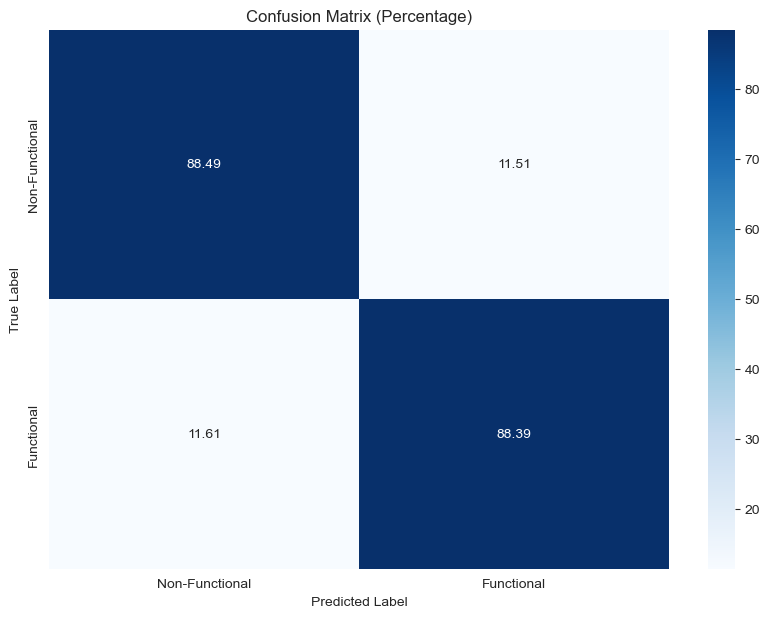

In [405]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


# Compute the normalized confusion matrix
cm_normalized = confusion_matrix(y_test, y_pred, normalize='true')

# Convert to percentage
cm_percentage = cm_normalized * 100

# Visualize the confusion matrix as percentages
plt.figure(figsize=(10,7))
sns.heatmap(cm_percentage, annot=True, fmt=".2f", cmap="Blues", xticklabels=['Non-Functional', 'Functional'], yticklabels=['Non-Functional', 'Functional'])
plt.title('Confusion Matrix (Percentage)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [410]:
def predict_req(req, expected, model, vectorizer, preprocess):
    df = pd.DataFrame([req], columns=['Requirement'])

    # Extract preprocessing parameters
    lemmatize = preprocess.get('lemmatize', False)
    stemming = preprocess.get('stemming', False)
    delete_stopwords = preprocess.get('delete_stopwords', False)
    with_numbers = preprocess.get('with_numbers', True)
    normalize_numbers = preprocess.get('normalize_numbers', False)
    
    X = [req_to_words(req, lemmatize=lemmatize,stemming= stemming, delete_stopwords=delete_stopwords, with_numbers=with_numbers, normalize_numbers=normalize_numbers) for req in df['Requirement']]
    X = vectorizer.transform(X)

    prediction = model.predict(X)
    predicted_label = 'Functional' if prediction[0] == 1 else 'Non-Functional'
    success = predicted_label == expected

    return predicted_label, success


In [411]:
def summarize_predictions(examples, model, vectorizer,preprocess):
    results = []
    for req, expected_label in examples:
        predicted_label, success = predict_req(req, expected_label, model, vectorizer, preprocess)
        results.append({
            'Requirement': req,
            'Expected Label': expected_label,
            'Predicted Label': predicted_label,
            'Success': success
        })
    return pd.DataFrame(results)

In [420]:
examples = [
    ("The system shall provide a login form that accepts a username and password.", 'Functional'),
    ("The application must ensure that response times are less than 2 seconds under normal load conditions.", 'Non-Functional'),
    ("All user passwords shall be encrypted before saving to the database.", 'Functional'),
    ("The software should be compatible with the Windows 10 operating system.", 'Non-Functional'),
    ("The interface shall refresh when new data is available.", 'Functional'),
    ("The product shall comply with international accessibility standards.", 'Non-Functional'),
    ("Database backup shall occur every 24 hours automatically.", 'Functional'),
    ("The system shall support a minimum of 500 concurrent user connections.", 'Functional'),
    ("The system’s mean time to failure shall be at least 10,000 hours.", 'Non-Functional'),
    ("Users must be able to complete the primary workflow in less than three minutes.", 'Non-Functional'),
    ("User settings must be retained for at least one year without login.", 'Non-Functional'),
    ("The system must support multi-language interfaces.", 'Functional'),
    ("Ensure data integrity during transaction processing.", 'Functional'),
    ("The application should load the user dashboard within 3 seconds.", 'Non-Functional'),
    ("Support data export to CSV and PDF formats.", 'Functional'),
    ("Must be compatible with both iOS and Android operating systems.", 'Non-Functional'),
    ("Implement two-factor authentication for user logins.", 'Functional'),
    ("The application must be available 99.9% of the time.", 'Non-Functional'),
    ("Automatically log out users after 30 minutes of inactivity.", 'Functional'),
    ("The system must scale to support up to 10,000 users simultaneously.", 'Non-Functional'),
    ("Provide a way to recover forgotten passwords securely.", 'Functional'),
    ("The system must encrypt sensitive data both at rest and in transit.", 'Non-Functional'),
    ("Support for user roles including admin, editor, and viewer.", 'Functional'),
    ("Ensure the application interface adheres to the latest web accessibility guidelines.", 'Non-Functional'),
    ("The software must be installable on both Windows and MacOS.", 'Non-Functional'),
    ("Offer a search function that returns results within 2 seconds.", 'Functional'),
    ("The mobile app should use no more than 50MB of data per hour of activity.", 'Non-Functional'),
    ("The platform must integrate seamlessly with third-party email services.", 'Functional'),
    ("User feedback must be addressed and incorporated within two release cycles.", 'Non-Functional'),
    ("Provide detailed logging of user actions to support auditing requirements.", 'Functional')
]


In [421]:
summary = summarize_predictions(examples, best_model, vectorizer, best_model_preprocess)
summary

,Requirement,Expected Label,Predicted Label,Success
0,The system shall provide a login form that acc...,Functional,Functional,True
1,The application must ensure that response time...,Non-Functional,Non-Functional,True
2,All user passwords shall be encrypted before s...,Functional,Non-Functional,False
3,The software should be compatible with the Win...,Non-Functional,Non-Functional,True
4,The interface shall refresh when new data is a...,Functional,Non-Functional,False
5,The product shall comply with international ac...,Non-Functional,Non-Functional,True
6,Database backup shall occur every 24 hours aut...,Functional,Non-Functional,False
7,The system shall support a minimum of 500 conc...,Functional,Non-Functional,False
8,The system’s mean time to failure shall be at ...,Non-Functional,Non-Functional,True
9,Users must be able to complete the primary wor...,Non-Functional,Non-Functional,True


In [422]:
import plotly.express as px

fig = px.pie(summary, names='Success', title ='Success of the model on my examples')
fig.show()